# Building an Image Caption Generator using CNN-LSTM from Scratch
**Deep Learning for Electrical & Computer Engineers**

**EC9170**

**Mini Project**

Group Members :


*   2021/E/010

*   2021/E/146

*   2021/E/185

## References

1. Building a CNN from Scratch in Keras  
   https://towardsdatascience.com/building-your-first-cnn-in-keras-b7f1bb50e5c0

2. Understanding Convolutional Neural Networks (CNNs)  
   https://cs231n.github.io/convolutional-networks/

3. Keras Conv2D Layer Documentation  
   https://keras.io/api/layers/convolution_layers/convolution2d/

4. MaxPooling2D and Flatten Layers in Keras  
   https://keras.io/api/layers/pooling_layers/max_pooling2d/  
   https://keras.io/api/layers/reshaping_layers/flatten/

5. Custom Image Classification with CNN  
   https://www.tensorflow.org/tutorials/images/cnn


# Introduction

This notebook is the first phase of our mini project: **"Building an Image Caption Generator using CNN-LSTM from Scratch"**.

The focus here is on building a **custom Convolutional Neural Network (CNN)** from scratch to extract meaningful visual features from input images. These image features will later serve as input to an LSTM-based decoder model that generates descriptive captions.

### What this notebook includes:
- Importing and preprocessing images.
- Designing a custom CNN using Keras.
- Extracting feature vectors from images.
- Preparing the image feature dataset for integration with the caption generation model.

Unlike many existing works that rely on pre-trained models like InceptionV3 or VGG16, this approach demonstrates how to build and train a CNN tailored for the captioning task from the ground up.



In [1]:
# Step 1: Import Required Libraries
import os
import string
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add


In [2]:
# Step 2 : Load Data
# Mount Google Drive (if using Colab)
from google.colab import drive
drive.mount('/content/drive')

# Define paths - UPDATE THESE TO MATCH YOUR ACTUAL PATHS
base_path = '/content/drive/MyDrive/OneDrive_1_3-12-2025/'
images_folder = os.path.join(base_path, 'Images')
captions_file = os.path.join(base_path, 'captions.txt')


# Verify the paths
print(f"Images Folder Path: {images_folder}")
print(f"Captions File Path: {captions_file}")


Mounted at /content/drive
Images Folder Path: /content/drive/MyDrive/OneDrive_1_3-12-2025/Images
Captions File Path: /content/drive/MyDrive/OneDrive_1_3-12-2025/captions.txt


In [3]:
# Check if it lists any image files from your folder
sample_images = os.listdir(images_folder)

print(f"Number of images found: {len(sample_images)}")
print(f"First 5 image file names: {sample_images[:5]}")


Number of images found: 8126
First 5 image file names: ['523991446_65dbc5a4a5.jpg', '531055369_936fd76a63.jpg', '61209225_8512e1dad5.jpg', '576093768_e78f91c176.jpg', '551664516_78a5131dc4.jpg']


In [5]:
# Step 3: Preprocess Captions & Match with Images
# Read caption file


with open(captions_file, 'r') as f:
    lines = f.readlines()

# Create a mapping: {image_num2: [caption1, caption2, ...]}
caption_dict = {}
for line in lines:
    if '\t' in line:
        img, caption = line.strip().split('\t')
    else:
        img, caption = line.strip().split(',', 1)

    img_id = img.split('_')[-1].split('.')[0]
    if img_id not in caption_dict:
        caption_dict[img_id] = []
    caption_dict[img_id].append(caption)

# Keep only entries with exactly 5 captions
caption_dict = {k: v for k, v in caption_dict.items() if len(v) == 5}

# Get all valid image paths and matched captions
image_features = []
all_captions = []

print(" Matching images and captions...\n")
count = 0
for filename in os.listdir(images_folder):
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
        img_id = filename.split('_')[-1].split('.')[0]
        if img_id in caption_dict:
            image_features.append(os.path.join(images_folder, filename))
            all_captions.append(caption_dict[img_id])

            # Only print output for the first 3 images
            if count < 3:
                print(f" Matched Image: {filename}")
                print(f"  Captions: {caption_dict[img_id]}")
                print("-" * 80)
            count += 1

print(f"\n Total Matched Images: {len(image_features)}")



 Matching images and captions...

 Matched Image: 523991446_65dbc5a4a5.jpg
  Captions: ['a large woman dances .', '"A zaftig woman in a tube top and jeans dancing outdoors , with a guitarist behind her ."', 'I woman in a red halter dances to guitar music .', 'The large dancer is slinging her hair around .', '"Woman flips her hair as she dances outdoors , band in background ."']
--------------------------------------------------------------------------------
 Matched Image: 531055369_936fd76a63.jpg
  Captions: ['A large woman carrying bags is standing outside of a shop .', '"A woman in purple walking past with a white bag in her hand , while an older man and woman are off to the side ."', 'a woman wearing a purple outfit walking down the sidewalk carrying a white bag .', 'People standing on a sidewalk near shops .', 'Three people and a baby carriage in front of a store .']
--------------------------------------------------------------------------------
 Matched Image: 61209225_8512e1dad

In [7]:
# Step 4: Build Custom CNN for Feature Extraction
# Step 4.1
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten # Import Conv2D and MaxPooling2D
def build_custom_cnn():
    inputs = Input(shape=(224, 224, 3))
    x = Conv2D(32, (3,3), activation='relu')(inputs)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(128, (3,3), activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    model = Model(inputs, x)
    return model

cnn_model = build_custom_cnn()

# Print model summary
print(" Custom CNN model summary:")
cnn_model.summary()

 Custom CNN model summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,244,672 (84.86 MB)

 Trainable params: 22,244,672 (84.86 MB)

 Non-trainable params: 0 (0.00 B)


 Extracting features from images using the custom CNN...



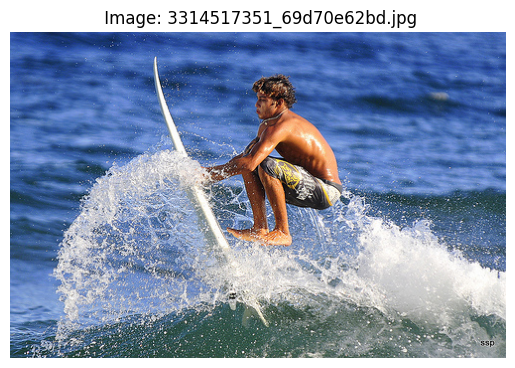

 Feature shape: (256,)
 Feature vector (first 10 values):
[0.1423803  0.04692002 0.         0.02173899 0.05845113 0.13520725
 0.         0.04109474 0.26393375 0.        ]
 Sample caption: startseq a person on a surfboard in the ocean . endseq
--------------------------------------------------------------------------------


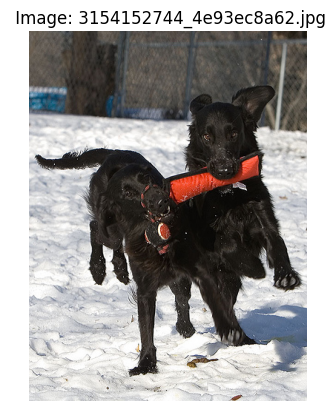

 Feature shape: (256,)
 Feature vector (first 10 values):
[0.11017196 0.05507832 0.         0.00933628 0.09184081 0.1334705
 0.         0.09717233 0.32940263 0.        ]
 Sample caption: startseq two dogs playing together in the snow . endseq
--------------------------------------------------------------------------------


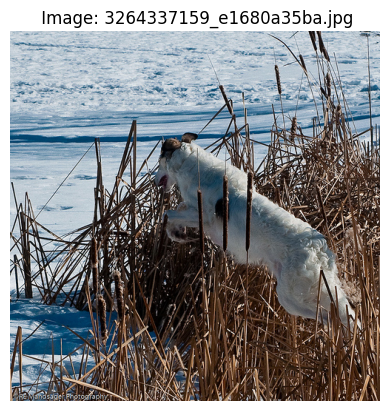

 Feature shape: (256,)
 Feature vector (first 10 values):
[0.10477979 0.03007967 0.         0.00123167 0.03667151 0.14908142
 0.         0.07651427 0.18834378 0.        ]
 Sample caption: startseq a white dog with an orange spot jumping through dried grass . endseq
--------------------------------------------------------------------------------


In [9]:
# Step 4.2 : Extract Features
import random
import matplotlib.pyplot as plt

def preprocess_image(img_path):
    """Resize and normalize an image."""
    img = Image.open(img_path).resize((224, 224))
    img = np.array(img)
    if img.shape[-1] == 4:
        img = img[..., :3]  # Remove alpha if present
    return img / 255.0

features = []
captions_list = []

print("\n Extracting features from images using the custom CNN...\n")

# Generate a list of 3 random indices from the total images
random_indices = random.sample(range(len(image_features)), 3)

for idx in random_indices:
    path = image_features[idx]
    # 1. Preprocess and extract feature (only ONCE per image)
    img = preprocess_image(path)
    feature = cnn_model.predict(np.expand_dims(img, axis=0), verbose=0).squeeze()

    # 2. Add the same feature for each of the 5 captions
    for cap in all_captions[idx]:
        features.append(feature)
        captions_list.append('startseq ' + cap.lower() + ' endseq')

    # 3. Visualize the image and info for the selected random images
    plt.imshow(Image.open(path))
    plt.axis('off')
    plt.title(f" Image: {os.path.basename(path)}")
    plt.show()

    # Print details
    print(f" Feature shape: {feature.shape}")
    print(f" Feature vector (first 10 values):\n{feature.squeeze()[:10]}")
    print(f" Sample caption: {captions_list[-1]}")
    print("-" * 80)

In [ ]:
# Create a dictionary: image_id -> list of captions
image_captions = {}

# Group captions by image
for image_id, caption in captions_df.values:  # iterate over the rows
    if image_id not in image_captions:
        image_captions[image_id] = []
    image_captions[image_id].append(caption)

# Check one sample image and its captions
sample_image_id = list(image_captions.keys())[0]
print(f"Image ID: {sample_image_id}")
print("Captions:")
for cap in image_captions[sample_image_id]:
    print(f"- {cap}")


Image ID: 1000268201_693b08cb0e.jpg
Captions:
- A child in a pink dress is climbing up a set of stairs in an entry way .
- A girl going into a wooden building .
- A little girl climbing into a wooden playhouse .
- A little girl climbing the stairs to her playhouse .
- A little girl in a pink dress going into a wooden cabin .


In [ ]:
import string

# Function to clean the captions
def preprocess_caption(caption):
    # Convert to lowercase
    caption = caption.lower()

    # Remove punctuation
    caption = caption.translate(str.maketrans('', '', string.punctuation))

    # Remove digits and extra spaces (optional)
    caption = ' '.join(caption.split())

    return caption


In [ ]:
# Create a new dictionary for cleaned captions
cleaned_captions = {}

for image_id, captions_list in image_captions.items():
    cleaned_captions[image_id] = [preprocess_caption(caption) for caption in captions_list]

# Check one sample
sample_image_id = list(cleaned_captions.keys())[0]
print(f"Image ID: {sample_image_id}")
print("Cleaned Captions:")
for cap in cleaned_captions[sample_image_id]:
    print(f"- {cap}")


Image ID: 1000268201_693b08cb0e.jpg
Cleaned Captions:
- a child in a pink dress is climbing up a set of stairs in an entry way
- a girl going into a wooden building
- a little girl climbing into a wooden playhouse
- a little girl climbing the stairs to her playhouse
- a little girl in a pink dress going into a wooden cabin


In [ ]:
# Create a new dictionary for cleaned captions
cleaned_captions = {}

# List of stop words to remove
stop_words = ['a', 'is', 'the','an','on','in','into','from','to','of','at','are','and','with','each','other']

# Preprocess the captions and clean them
for image_id, captions_list in image_captions.items():
    cleaned_captions[image_id] = [preprocess_caption(caption) for caption in captions_list]

# Function to clean each caption
def preprocess_caption(caption):
    words = caption.split()
    # Filter out the stop words
    cleaned_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(cleaned_words)

# Create a set to store unique words
vocabulary = set()

# Loop through all cleaned captions and extract words
for image_id in cleaned_captions:
    for caption in cleaned_captions[image_id]:
        words = caption.split()
        vocabulary.update(words)

# Calculate the vocabulary size
vocabulary_size = len(vocabulary)
print(f"Vocabulary Size: {vocabulary_size}")


Vocabulary Size: 8828


In [ ]:
from collections import Counter

# List of stop words to remove (again ensuring they are cleaned properly)
stop_words = ['a', 'is', 'the','an','on','in','into','from','to','of','at','are','and','with','each','other','.']

# Create a dictionary to store the most important words for each image
image_important_words = {}

# Loop through the dictionary and clean the captions while counting frequencies
for image_id, captions_list in cleaned_captions.items():
    # Combine all captions for the image into one large text
    all_words = []
    for caption in captions_list:
        words = caption.split()
        # Clean the words by removing stop words
        all_words.extend([word for word in words if word.lower() not in stop_words])

    # Count the frequency of each word
    word_freq = Counter(all_words)

    # Get the 4 most common words (important words)
    most_common_words = [word for word, freq in word_freq.most_common(4)]

    # Store in dictionary
    image_important_words[image_id] = most_common_words





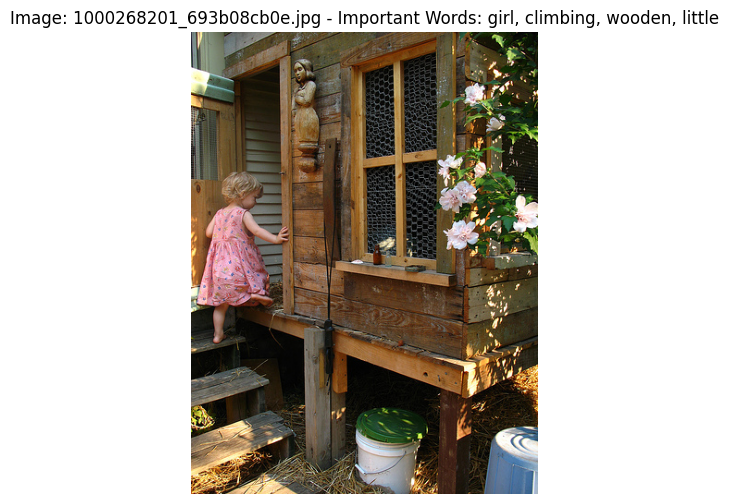

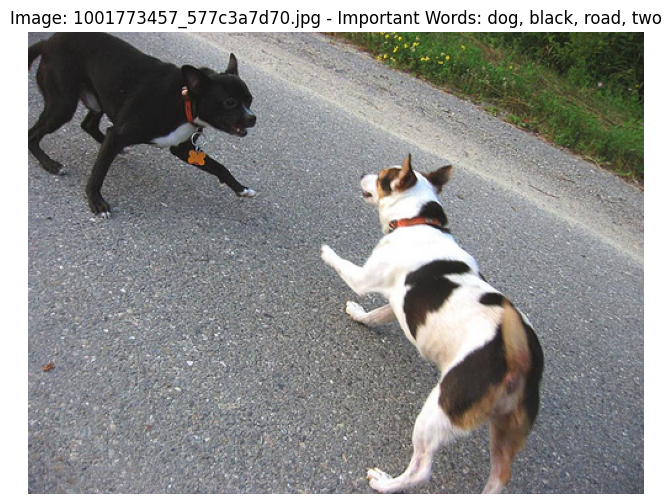

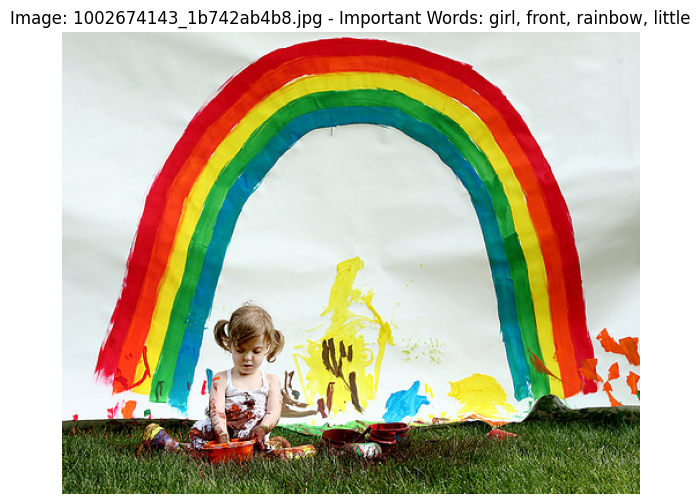

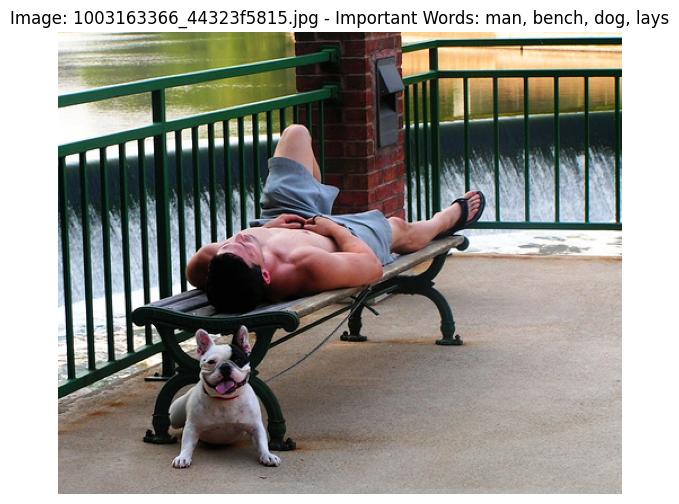

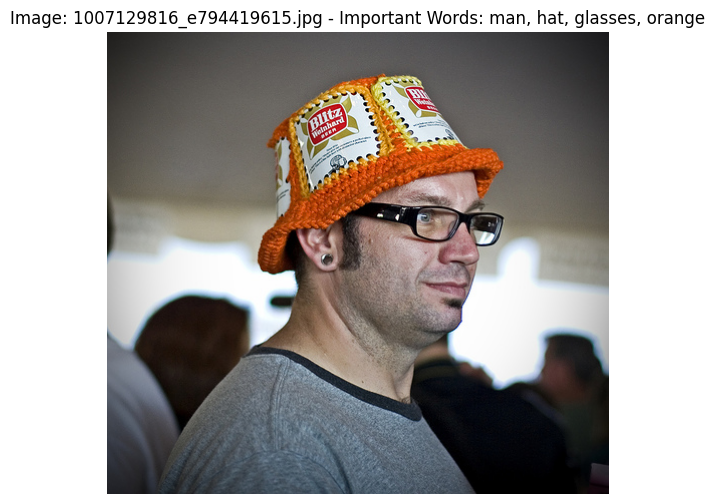

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter

# List of stop words to remove
stop_words = ['a', 'is', 'the','an','on','in','into','from','to','of','at','are','and','with','each','other','.']

# Create a dictionary to store the most important words for each image
image_important_words = {}

# Loop through the dictionary and clean the captions while counting frequencies
for image_id, captions_list in cleaned_captions.items():
    # Combine all captions for the image into one large text
    all_words = []
    for caption in captions_list:
        words = caption.split()
        # Remove stop words ('a', 'is', 'the') from the words
        cleaned_words = [word for word in words if word.lower() not in stop_words]
        all_words.extend(cleaned_words)

    # Count the frequency of each word
    word_freq = Counter(all_words)

    # Get the 4 most common words (important words)
    most_common_words = [word for word, freq in word_freq.most_common(4)]

    # Store in the dictionary
    image_important_words[image_id] = most_common_words

# Show the important words for only 5 images
sample_images = list(image_important_words.items())[:5]

# Display images with their important words
for image_id, words in sample_images:
    # Load the image using matplotlib
    img_path = f"./images/{image_id}"  # Modify this path based on your actual image directory
    img = mpimg.imread(img_path)

    # Plot the image
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis('off')

    # Display the important words
    plt.title(f"Image: {image_id} - Important Words: {', '.join(words)}", fontsize=12)
    plt.show()


In [ ]:
# List of stop words to remove
stop_words = ['a', 'is', 'the', 'an', 'on', 'in', 'into', 'from', 'to', 'of', 'at', 'are', 'and', 'with', 'each', 'other']

# Create the dictionary: image_id -> list of cleaned important words
image_important_words_cleaned = {}

# Preprocess the captions and clean them
for image_id, captions_list in image_important_words.items():
    cleaned_words = [word for word in captions_list if word.lower() not in stop_words]
    image_important_words_cleaned[image_id] = cleaned_words

# Now, `image_important_words_cleaned` holds the cleaned important words for each image


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image

# Function to preprocess images
def load_and_preprocess_image(img_path, target_size=(299, 299)):
    img = image.load_img(img_path, target_size=target_size)  # Resize image
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = img_array / 255.0  # Normalize the image (scale pixel values to [0, 1])
    return img_array

# Prepare image paths for training
image_paths = [os.path.join(images_folder, image_id) for image_id in image_important_words_cleaned.keys()]

# Initialize an empty list to store the processed images
X_train = []

# Loop through the image paths and process them
for img_path in image_paths:
    try:
        # Try to preprocess the image
        img_array = load_and_preprocess_image(img_path)
        X_train.append(img_array)  # Add the preprocessed image to the list
    except FileNotFoundError:
        # Handle the case where the image is missing
        print(f"Image not found: {img_path}")  # Notify which image is missing

# Convert the list of images to a NumPy array
X_train = np.array(X_train)

# Check the shape of X_train to verify the image data
print(f"X_train shape: {X_train.shape}")


Image not found: ./images\2387197355_237f6f41ee.jpg
X_train shape: (8090, 299, 299, 3)


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Extract all important words across all captions
all_words = [word for words in image_important_words_cleaned.values() for word in words]

# Initialize the LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(all_words)  # Fit on all words to create a vocabulary

# Convert the important words of each image to one-hot encoded vectors
encoded_labels = {}
for image_id, words in image_important_words_cleaned.items():
    word_indices = label_encoder.transform(words)  # Convert words to indices
    one_hot_labels = to_categorical(word_indices, num_classes=len(label_encoder.classes_))  # One-hot encode
    encoded_labels[image_id] = one_hot_labels

# Convert the dictionary of one-hot labels into a list (ensure it matches the order of images)
y_train = np.array([encoded_labels[image_id] for image_id in image_important_words_cleaned.keys()])

# Check the shape of y_train
print(f"y_train shape: {y_train.shape}")


y_train shape: (8091, 4, 2064)


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image

# Initialize the list to hold processed images
X_train = []
y_train_cleaned = []

# Assuming image_paths and image_important_words_cleaned are already defined
missing_images = []

# Loop through image_paths and check if the image exists
for img_path in image_paths:
    if os.path.exists(img_path):  # Check if the image exists
        # Preprocess the image and add it to X_train
        img_array = load_and_preprocess_image(img_path)
        X_train.append(img_array)

        # Get the corresponding labels (important words)
        image_id = os.path.basename(img_path)
        y_train_cleaned.append(encoded_labels[image_id])  # Assuming encoded_labels is already created
    else:
        missing_images.append(img_path)  # Keep track of missing images

# Convert the list of images and cleaned labels into NumPy arrays
X_train = np.array(X_train)
y_train_cleaned = np.array(y_train_cleaned)

# Print the final shapes to verify
print(f"X_train shape after removing missing images: {X_train.shape}")
print(f"y_train shape after removing missing captions: {y_train_cleaned.shape}")

# Optionally, print the missing images
print("Missing images:", missing_images)


X_train shape after removing missing images: (8090, 299, 299, 3)
y_train shape after removing missing captions: (8090, 4, 2064)
Missing images: ['./images\\2387197355_237f6f41ee.jpg']


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into train and test (80% train, 20% test)
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_train, y_train_cleaned, test_size=0.2, random_state=42
)

# Check the shape of the resulting train and test splits
print(f"X_train_split shape: {X_train_split.shape}")
print(f"y_train_split shape: {y_train_split.shape}")
print(f"X_test_split shape: {X_test_split.shape}")
print(f"y_test_split shape: {y_test_split.shape}")


X_train_split shape: (6472, 299, 299, 3)
y_train_split shape: (6472, 4, 2064)
X_test_split shape: (1618, 299, 299, 3)
y_test_split shape: (1618, 4, 2064)


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming you have your training data in X_train and y_train
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_cleaned, test_size=0.2, random_state=42)

# Now X_train, y_train will be used for training and X_val, y_val will be used for validation


In [ ]:
from tensorflow.keras import layers, models
import keras_tuner as kt
import tensorflow as tf

def create_cnn_model(input_shape, num_classes, num_words=4, filters=32, kernel_size=3, pooling_type='max', neurons=2048, learning_rate=0.001):
    model = models.Sequential()

    # Convolutional layers with Batch Normalization and configurable hyperparameters
    model.add(layers.Conv2D(filters, (kernel_size, kernel_size), activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())  # Add Batch Normalization
    if pooling_type == 'max':
        model.add(layers.MaxPooling2D((2, 2)))
    elif pooling_type == 'average':
        model.add(layers.AvgPool2D((2, 2)))

    model.add(layers.Conv2D(filters*2, (kernel_size, kernel_size), activation='relu'))
    model.add(layers.BatchNormalization())  # Add Batch Normalization
    if pooling_type == 'max':
        model.add(layers.MaxPooling2D((2, 2)))
    elif pooling_type == 'average':
        model.add(layers.AvgPool2D((2, 2)))

    model.add(layers.Conv2D(filters*4, (kernel_size, kernel_size), activation='relu'))
    model.add(layers.BatchNormalization())  # Add Batch Normalization
    if pooling_type == 'max':
        model.add(layers.MaxPooling2D((2, 2)))
    elif pooling_type == 'average':
        model.add(layers.AvgPool2D((2, 2)))

    model.add(layers.Conv2D(filters*4, (kernel_size, kernel_size), activation='relu'))
    model.add(layers.BatchNormalization())  # Add Batch Normalization
    if pooling_type == 'max':
        model.add(layers.MaxPooling2D((2, 2)))
    elif pooling_type == 'average':
        model.add(layers.AvgPool2D((2, 2)))

    # Use Global Average Pooling instead of Flatten
    model.add(layers.GlobalAveragePooling2D())  # This will reduce the spatial dimensions to 1D

    # Fully connected layer with configurable neurons
    model.add(layers.Dense(neurons, activation='relu'))  # Number of neurons can be tuned

    # Output layer: 4 words, each with num_classes possible classes (one-hot encoded)
    model.add(layers.Dense(num_classes * num_words, activation='softmax'))  # Flattened output for 4 words

    # Reshape to (None, 4, num_classes)
    model.add(layers.Reshape((num_words, num_classes)))

    # Optimizer with learning rate tuning
    optimizer_instance = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer_instance, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


# Define the hyperparameter search space using Keras Tuner
def model_builder(hp):
    input_shape = (299, 299, 3)
    num_classes = 2064
    num_words = 4

    # Define the hyperparameters to tune
    filters = hp.Int('filters', min_value=32, max_value=128, step=32)
    kernel_size = hp.Int('kernel_size', min_value=3, max_value=5, step=1)
    pooling_type = hp.Choice('pooling_type', values=['max', 'average'])
    neurons = hp.Int('neurons', min_value=1024, max_value=4096, step=1024)
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')

    model = create_cnn_model(input_shape, num_classes, num_words, filters, kernel_size, pooling_type, neurons, learning_rate)

    return model

# Initialize the Keras Tuner and start the search
tuner = kt.RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=5,  # Number of hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to run for each trial
    directory='my_dir',
    project_name='cnn_hyperparameter_tuning'
)

# You can use validation data or use a validation split during training
tuner.search(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_val, y_val))

# To get the best model and hyperparameters:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]


Reloading Tuner from my_dir\cnn_hyperparameter_tuning\tuner0.json


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# After tuning, get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best hyperparameters:", best_hyperparameters.values)

# Define EarlyStopping and ModelCheckpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Train the model with best hyperparameters for 20 epochs
best_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val),
               callbacks=[early_stopping, checkpoint])

# Load the best model after training
best_model.load_weights('best_model.h5')

# Save the model weights after training
best_model.save_weights('cnn_model_weights.h5')

# Evaluate the final model
final_loss, final_accuracy = best_model.evaluate(X_val, y_val)
print(f"Final model loss: {final_loss}, accuracy: {final_accuracy}")


Best hyperparameters: {'filters': 96, 'kernel_size': 3, 'pooling_type': 'max', 'neurons': 4096, 'learning_rate': 0.0001057483097998785}
Epoch 1/10
203/203 [==============================] - ETA: 0s - loss: 4.5790 - accuracy: 0.0974
Epoch 1: val_loss improved from inf to 5.92295, saving model to best_model.h5
203/203 [==============================] - 1406s 7s/step - loss: 4.5790 - accuracy: 0.0974 - val_loss: 5.9229 - val_accuracy: 0.0842
Epoch 2/10
203/203 [==============================] - ETA: 0s - loss: 4.3549 - accuracy: 0.1034
Epoch 2: val_loss did not improve from 5.92295
203/203 [==============================] - 1430s 7s/step - loss: 4.3549 - accuracy: 0.1034 - val_loss: 6.0373 - val_accuracy: 0.0871
Epoch 3/10
203/203 [==============================] - ETA: 0s - loss: 4.1271 - accuracy: 0.1124
Epoch 3: val_loss did not improve from 5.92295
203/203 [==============================] - 1399s 7s/step - loss: 4.1271 - accuracy: 0.1124 - val_loss: 6.2703 - val_accuracy: 0.0853
Epoch

51/51 [==============================] - 80s 2s/step - loss: 5.9229 - accuracy: 0.0842
Test set loss: 5.922945022583008, Test set accuracy: 0.0842088982462883
1/1 [==============================] - 0s 88ms/step


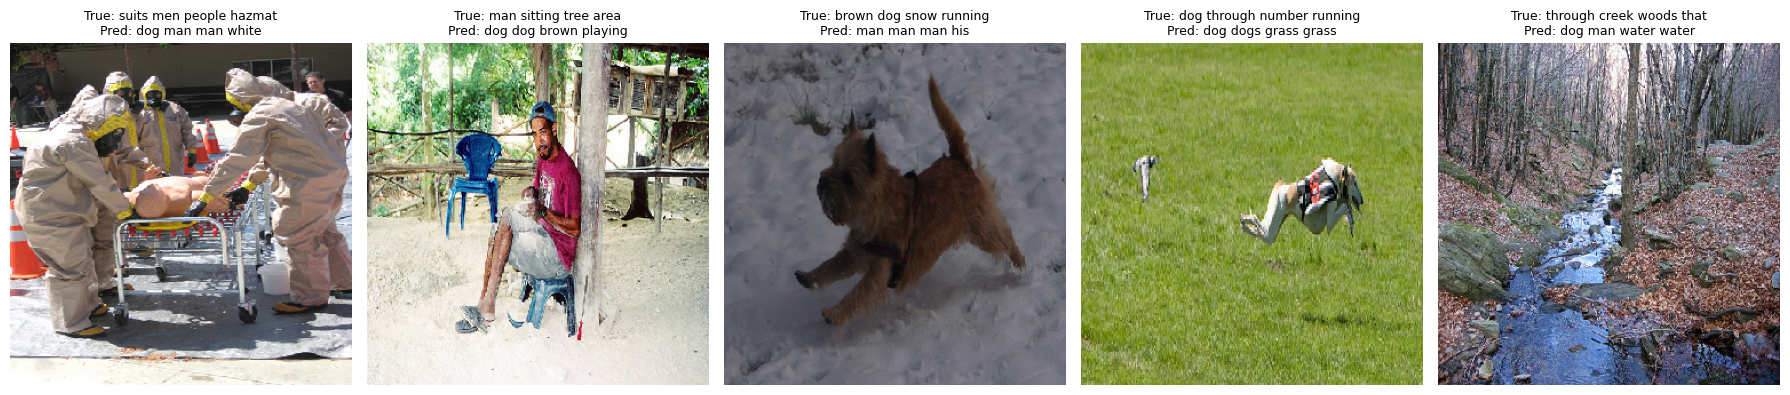

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Evaluate the final model on the test set
final_loss, final_accuracy = best_model.evaluate(X_test_split, y_test_split)
print(f"Test set loss: {final_loss}, Test set accuracy: {final_accuracy}")

# Visualize predictions for 5 random images
num_images = 5
num_words = 4
random_indices = np.random.choice(len(X_test_split), num_images, replace=False)

fig, axes = plt.subplots(1, num_images, figsize=(18, 6))

for i, idx in enumerate(random_indices):
    # Get the image and the true label
    image = X_test_split[idx]
    true_one_hot = y_test_split[idx]  # shape: (4, 2064)

    # Model prediction
    prediction = best_model.predict(np.expand_dims(image, axis=0))  # shape: (1, 4, 2064)
    pred_indices = prediction.argmax(axis=2)[0]  # shape: (4,)
    pred_words = label_encoder.inverse_transform(pred_indices)

    # Ground truth
    true_indices = true_one_hot.argmax(axis=1)  # shape: (4,)
    true_words = label_encoder.inverse_transform(true_indices)

    # Show the image
    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(f"True: {' '.join(true_words)}\nPred: {' '.join(pred_words)}", fontsize=9)

plt.tight_layout()
plt.show()
